In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 17 15:03:29 2024

@author: maxim
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as mst
from cycler import cycler
from scipy.signal import savgol_filter
from datetime import datetime
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.optimize import fmin, minimize
import glob
import matplotlib.cm as cm
import pickle






"""Funktionen"""
def load (initpath,datei,skip,separation):
    
    initpath= initpath +"/" + datei
    with open(initpath, 'r') as f:
        temp_df = np.array(pd.read_csv(f, comment='~', skiprows=skip, sep=separation,
                           encoding='latin1', header=None, on_bad_lines='skip',
                           decimal='.'))
        return temp_df
    

def filtplot(array,line1,line2,plot,col):
    temp=array[array[:,1]>=line1]
    temp=temp[temp[:,1]<=line2]
    if plot: plt.plot(temp[:,0]-temp[0,0],temp[:,col])
    
    return temp


def ocv(array,line):
    temp=[]
    for i in range(len(array)):
        if array[i-1,1]==line and (array[i,1]==line+1 or array[i,1]==line-1):
            temp.append(array[i-1,:])
            
    return np.array(temp)

def dva(dataTime, dataU, dataAh):
    data = []
    for i in range(len(dataU)-1):
            dAh = dataAh[i+1] - dataAh[i]
            dU = dataU[i+1] - dataU[i]
            if dataU[0]>dataU[-1]:
                UAh = -abs(dU/dAh)
            else:
                UAh = abs(dU/dAh)
                
            if UAh!=np.inf and abs(UAh)<10000:
                data.append([dataTime[i],UAh,dataAh[i]-min(dataAh)])
    data=np.array(data)
    return data

def ica(dataTime, dataU, dataAh, step):
    data = []
    for i in range(len(dataU)-step):
            dAh = dataAh[i+step] - dataAh[i] 
            dU = dataU[i+step] - dataU[i]
            if dU!=0:
                if dataU[0]>dataU[-1]:
                    UAh = -abs(dAh/dU)
                else:
                    UAh = abs(dAh/dU)
                
            if UAh!=np.inf:
                data.append([dataTime[i],UAh,dataU[i]])
                # data.append([dataTime[i],UAh,dataAh[i]-min(dataAh)])
    data=np.array(data)
    return data

def interp(ydata, xval):
    xq = np.arange(min(xval),max(xval),0.02)    

    x = np.array(xval, dtype=float)

    vq = interp1d(x, ydata)
    yint = vq(xq)
    return np.column_stack([xq,yint])

def consecutive(data, stepsize=1):
    return np.split(data, np.where(np.diff(data[:,0]) >= stepsize)[0]+1)

In [8]:
"""OCV Dict laden"""
with open('OCV_mean.pkl', 'rb') as file:
    data = pickle.load(file)

In [3]:
"""DVA und ICA berechnen"""
DVA={}
ICA={}
DeltaOCV={}
for za in data.keys():
    DVA[za]={}
    ICA[za]={}
    DeltaOCV[za]={}

    for mode in data[za].keys():
        DVA[za][mode]={}
        ICA[za][mode]={}
        DeltaOCV[za][mode]={}

        for grad in data[za][mode].keys():
            DVA[za][mode][grad]={}
            ICA[za][mode][grad]={}
            mean_data = data[za][mode][grad]['C/20']['mean']
            DeltaOCV[za][mode][grad] = np.column_stack((mean_data[:, 2], mean_data[:, 4]))
           
            for c in data[za][mode][grad].keys():
                DVA[za][mode][grad][c]=dva(data[za][mode][grad][c]["mean"][:,0],data[za][mode][grad][c]["mean"][:,2],data[za][mode][grad][c]["mean"][:,4])
                ICA[za][mode][grad][c]=ica(data[za][mode][grad][c]["mean"][:,0],data[za][mode][grad][c]["mean"][:,2],data[za][mode][grad][c]["mean"][:,4],step=2)
    print(za+" fertig")           


AMNMC fertig
dS24NCA fertig
HEL23NMC fertig


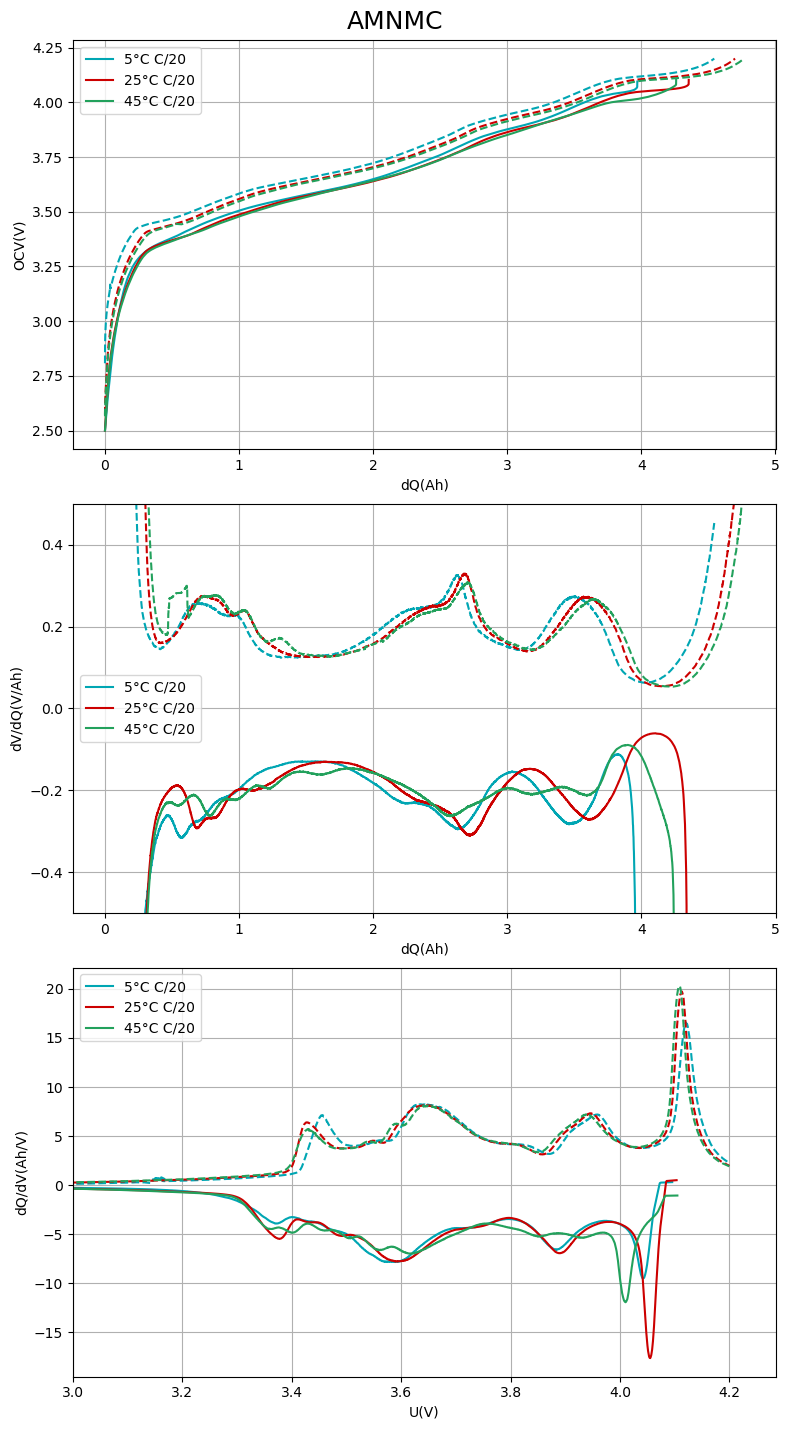

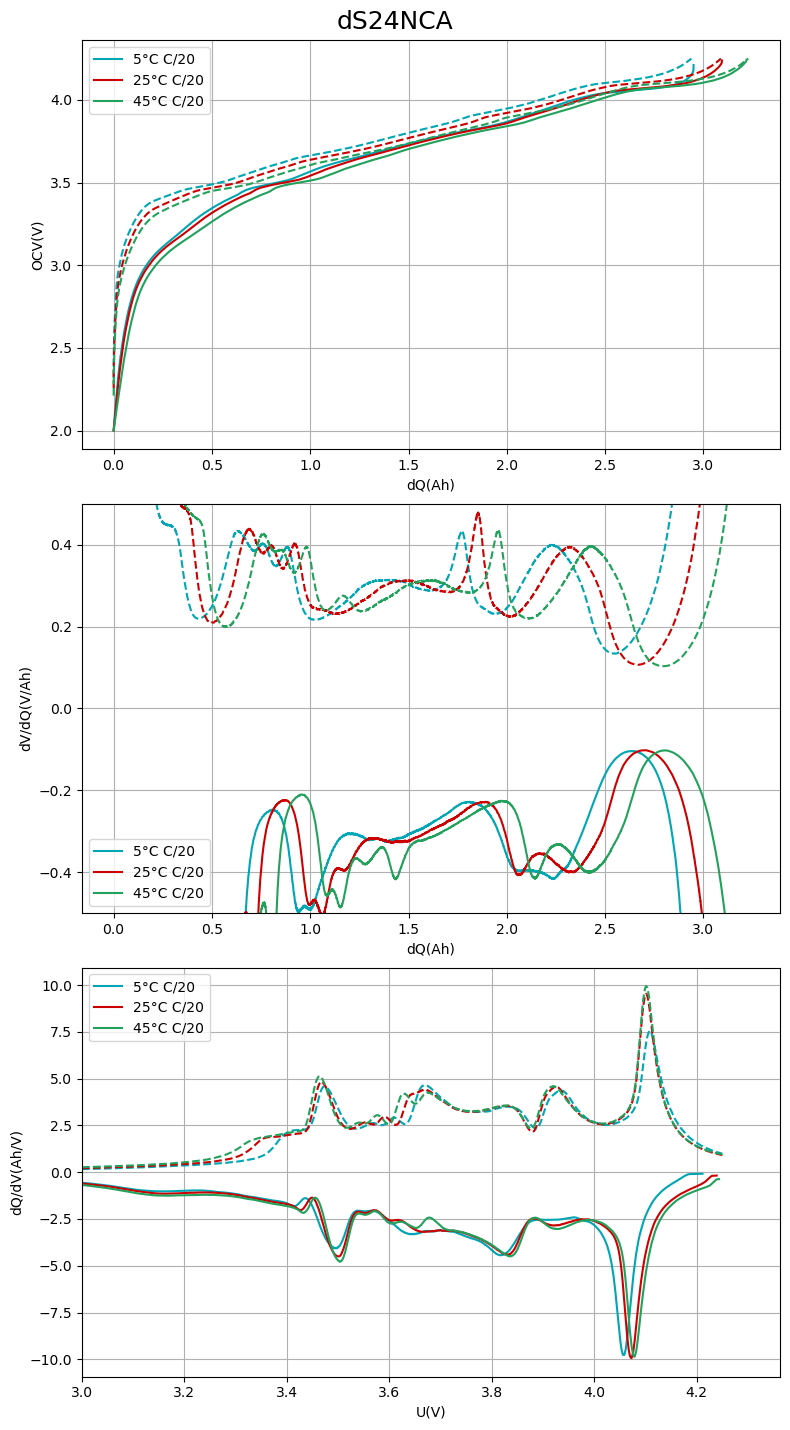

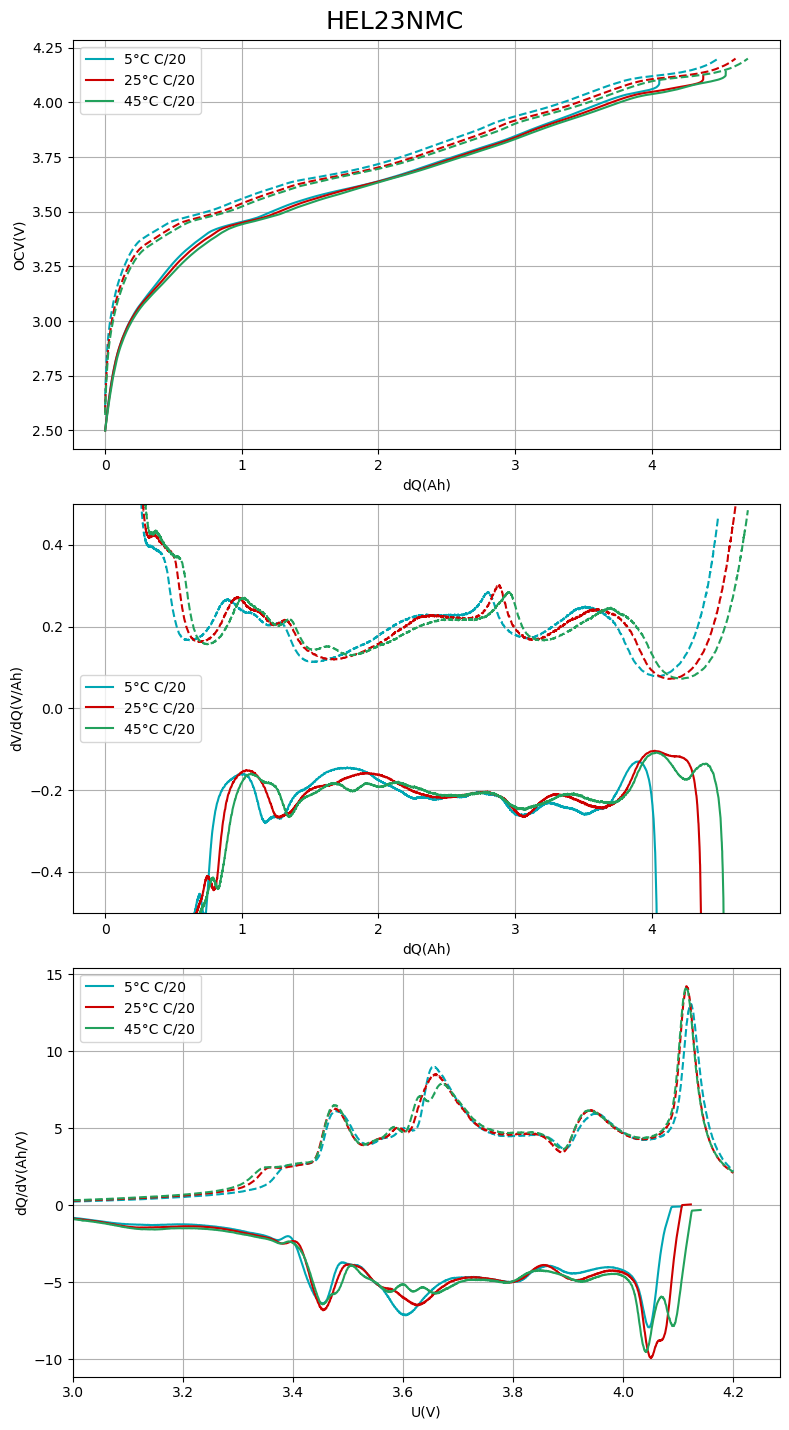

In [4]:
"""Temp vergleich"""
colors=[ '#00a6b3','#cc0000','#22a15c', '#ff8000','#9900cc']
co=0
# fig, axes = plt.subplots(3, 1, figsize=(8, 6))

# Plot 1: OCV Daten

savgol={"C/20":101,"C/5":91,"C/2":61}
for z in data.keys():
    co=0
    fig, axes = plt.subplots(3, 1, figsize=(8, 15))

    for t in data[z]["ch"].keys():
        ch = data[z]["ch"][t]["C/20"]["mean"]
        dis = data[z]["dis"][t]["C/20"]["mean"]
        dQ_ch = ch[:, 4] - min(ch[:, 4])
        dQ_dis = dis[:, 4] - min(dis[:, 4])


        axes[0].plot(dQ_ch, ch[:, 2], linestyle='--', color=colors[co])
        axes[0].plot(dQ_dis, dis[:, 2], color=colors[co],label=t+" C/20")
        
        
        dva_ch = DVA[z]["ch"][t]["C/20"]
        dva_dis = DVA[z]["dis"][t]["C/20"]
    
        dvaCH_filt = savgol_filter(dva_ch[:, 1], savgol["C/20"], 1)
        dvaDIS_filt = savgol_filter(dva_dis[:, 1], savgol["C/20"], 1)
        
        axes[1].plot(dva_ch[:, 2], dvaCH_filt, linestyle='--', color=colors[co])
        axes[1].plot(dva_dis[:, 2], dvaDIS_filt, color=colors[co], label=t+" C/20")
        
        
        ica_ch = ICA[z]["ch"][t]["C/20"]
        ica_dis = ICA[z]["dis"][t]["C/20"]
        icaCH_filt = savgol_filter(ica_ch[:, 1], 101, 1)
        icaDIS_filt = savgol_filter(ica_dis[:, 1], 101, 1)
        axes[2].plot(ica_ch[:, 2], icaCH_filt, linestyle='--', color=colors[co])
        axes[2].plot(ica_dis[:, 2], icaDIS_filt, color=colors[co], label=t+" C/20")

        
        co += 1
    # fig.title(z)
    axes[0].set_ylabel('OCV(V)')
    axes[0].set_xlabel('dQ(Ah)')
    axes[0].grid()
    axes[0].legend()
    axes[1].set_ylabel('dV/dQ(V/Ah)')
    axes[1].set_xlabel('dQ(Ah)')
    axes[1].set_ylim(-0.5, 0.5)
    axes[1].grid()
    axes[1].legend()
    axes[2].set_ylabel('dQ/dV(Ah/V)')
    axes[2].set_xlabel('U(V)')
    axes[2].set_xlim(left=3)
    # axes[2].set_ylim(-1,1)
    axes[2].grid()
    axes[2].legend()
    # Passe das Layout der Subplots an
    plt.tight_layout()
    
    # Setzt den Titel oberhalb der Figur
    fig.suptitle(z, fontsize=18, y=0.95)
    plt.subplots_adjust(top=0.93)  # Platz für den Titel schaffen
    
    # Zeige den Plot
    plt.show()
    

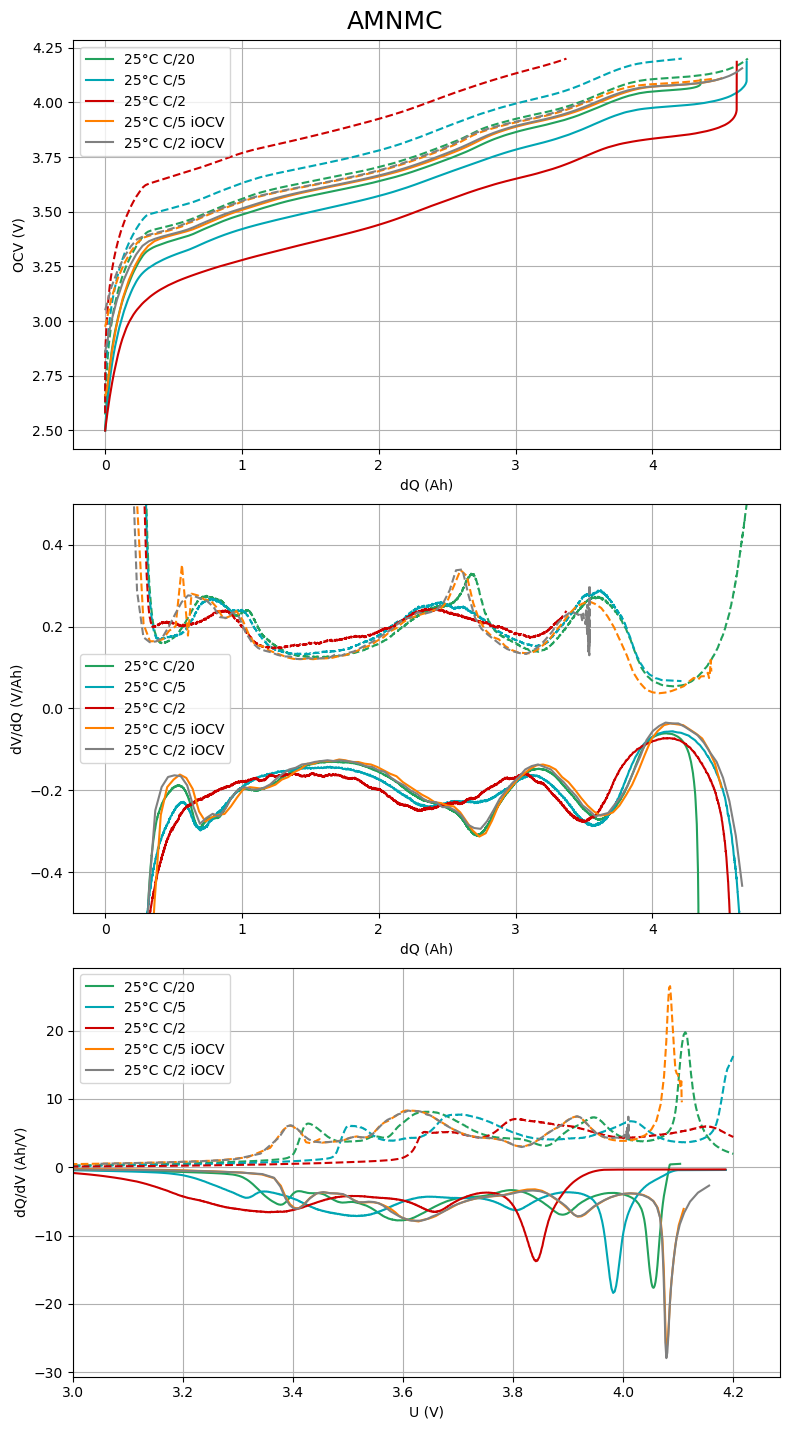

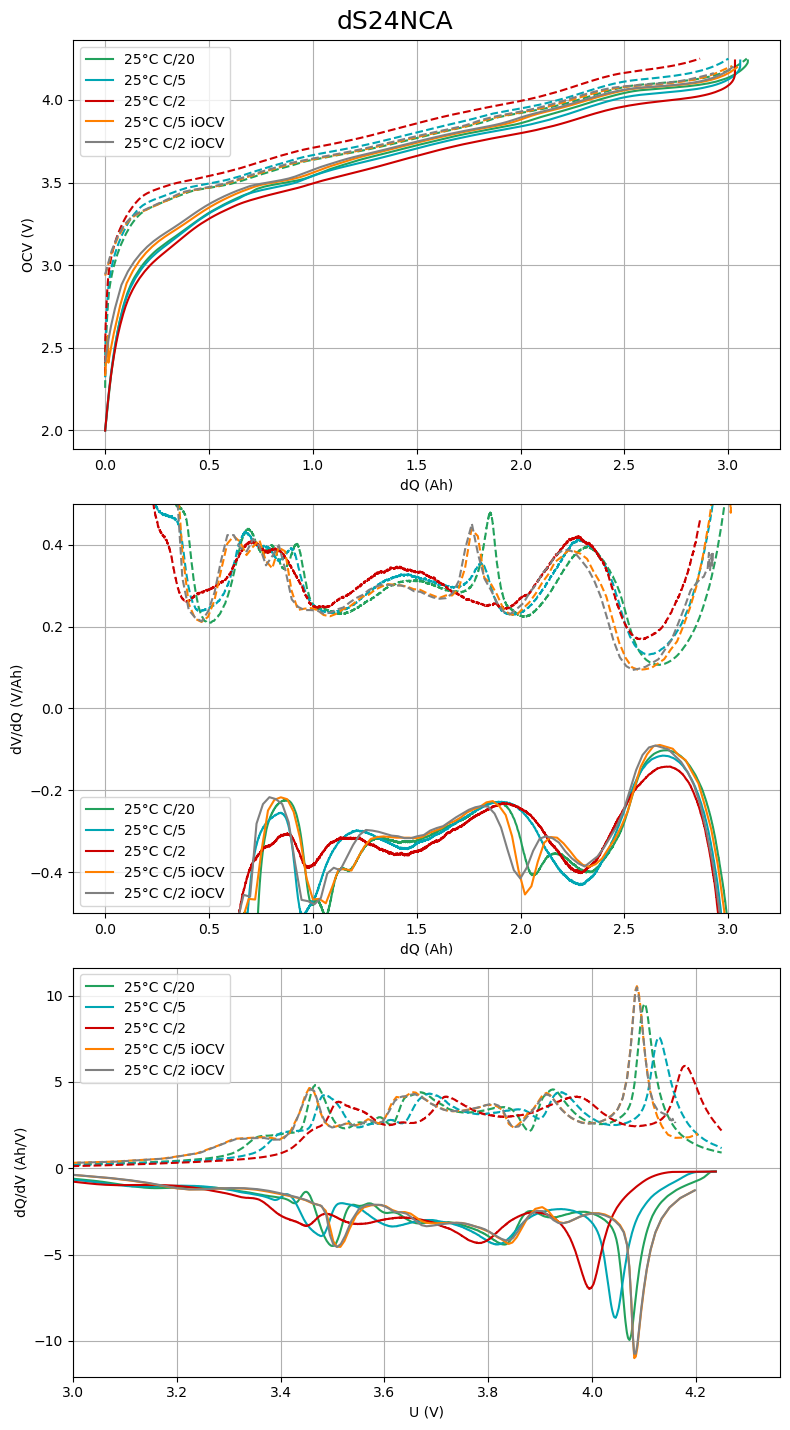

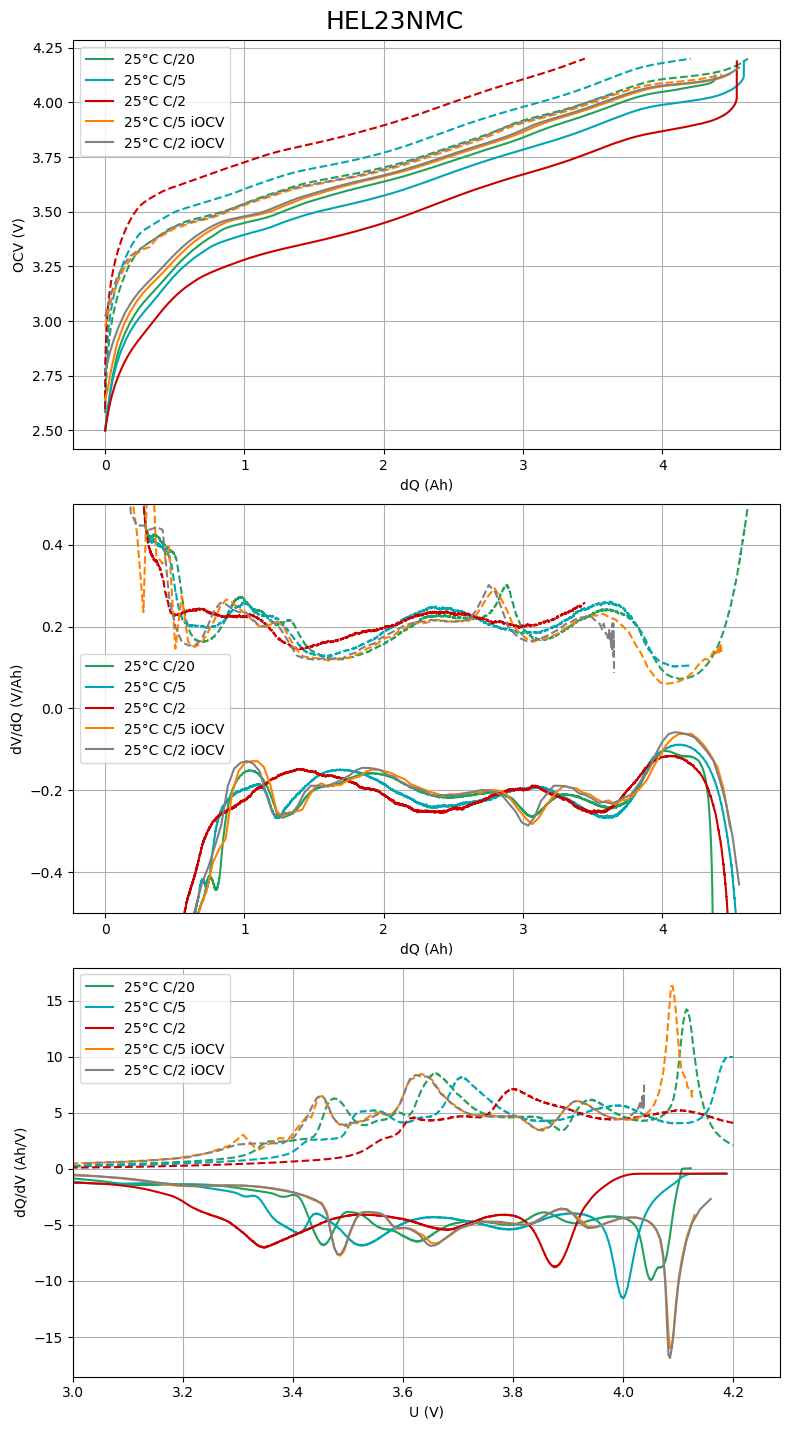

In [5]:
"""C-Raten plotten"""
colors = ['#22a15c', '#00a6b3', '#cc0000', '#ff8000', '#808080']
temp = ["25°C", "45°C"]
savgol = {"C/20": 101, "C/5": 91, "C/2": 61}

for z in data.keys():
    co = 0
    fig, axes = plt.subplots(3, 1, figsize=(8, 15))

    for c in data[z]["ch"]["25°C"].keys():
        ch = data[z]["ch"]["25°C"][c]["mean"]
        dis = data[z]["dis"]["25°C"][c]["mean"]
        dQ_ch = ch[:, 4] - min(ch[:, 4])
        dQ_dis = dis[:, 4] - min(dis[:, 4])
    
        axes[0].plot(dQ_ch, ch[:, 2], linestyle='--', color=colors[co])
        axes[0].plot(dQ_dis, dis[:, 2], color=colors[co], label="25°C " + c)
        
        dva_ch = DVA[z]["ch"]["25°C"][c]
        dva_dis = DVA[z]["dis"]["25°C"][c]
        if "iOCV" not in c:
            dvaCH_filt = savgol_filter(dva_ch[:, 1], savgol[c], 1)
            dvaDIS_filt = savgol_filter(dva_dis[:, 1], savgol[c], 1)
        else:
            dvaCH_filt = dva_ch[:, 1]
            dvaDIS_filt = dva_dis[:, 1]
        
        axes[1].plot(dva_ch[:, 2], dvaCH_filt, linestyle='--', color=colors[co])
        axes[1].plot(dva_dis[:, 2], dvaDIS_filt, color=colors[co], label="25°C " + c)
        
        ica_ch = ICA[z]["ch"]["25°C"][c]
        ica_dis = ICA[z]["dis"]["25°C"][c]
        if "iOCV" not in c:
            icaCH_filt = savgol_filter(ica_ch[:, 1], 101, 1)
            icaDIS_filt = savgol_filter(ica_dis[:, 1], 101, 1)
        else:
            icaCH_filt = ica_ch[:, 1]
            icaDIS_filt = ica_dis[:, 1]
        
        axes[2].plot(ica_ch[:, 2], icaCH_filt, linestyle='--', color=colors[co])
        axes[2].plot(ica_dis[:, 2], icaDIS_filt, color=colors[co], label="25°C " + c)
        
        co += 1

    # Beschriftungen und Einstellungen für jeden Plot
    axes[0].set_ylabel('OCV (V)')
    axes[0].set_xlabel('dQ (Ah)')
    axes[0].grid()
    axes[0].legend()
    
    axes[1].set_ylabel('dV/dQ (V/Ah)')
    axes[1].set_xlabel('dQ (Ah)')
    axes[1].set_ylim(-0.5, 0.5)
    axes[1].grid()
    axes[1].legend()
    
    axes[2].set_ylabel('dQ/dV (Ah/V)')
    axes[2].set_xlabel('U (V)')
    axes[2].set_xlim(left=3)
    axes[2].grid()
    axes[2].legend()
    
    # Passe das Layout der Subplots und den Abstand an
    plt.tight_layout()
    
    # Setzt den Titel oberhalb der Figur
    fig.suptitle(z, fontsize=18, y=0.95)
    plt.subplots_adjust(top=0.93)  # Platz für den Titel schaffen
    
    # Zeige den Plot
    plt.show()

Delta OCV berechnen:

In [6]:
"""Delta OCV Variante 2"""
DeltaOCV_2={}
for cell, directions in data.items():
    DeltaOCV_2[cell] = {}
    
    for direction, temps in directions.items():
        #cv phasen nach entladung beim charge am anfang abziehen
        if direction=="ch":
            temp1=np.where(directions[direction]["45°C"]['C/20']['mean'][:,4]>=data[cell]["dis"]["45°C"]["C/20"]["mean"][-1,4])
            temp2=np.where(directions[direction]["5°C"]['C/20']['mean'][:,4]>=data[cell]["dis"]["5°C"]["C/20"]["mean"][-1,4])
            g1=temp1[0][0]
            g2=temp2[0][0]
        else:
            g1=0
            g2=0
        capacity1 = directions[direction]["45°C"]['C/20']['mean'][g1:,4].copy() # Kapazitätswerte von Array 1
        voltage1 = directions[direction]["45°C"]['C/20']['mean'][g1:,2].copy()  # Spannungen von Array 1
        capacity2 = directions[direction]["5°C"]['C/20']['mean'][g2:,4].copy() # Kapazitätswerte von Array 2
        voltage2 = directions[direction]["5°C"]['C/20']['mean'][g2:,2].copy() # Spannungen von Array 2
        
        capacity1-=capacity1[0]
        capacity2-=capacity2[0]
        common_capacity = np.linspace(max(min(capacity1), min(capacity2)),
                                        min(max(capacity1), max(capacity2)), 1000)

        f1=interp1d(capacity1,voltage1,kind='linear')
        f2=interp1d(capacity2,voltage2,kind='linear')
        interp_voltage1=f1(common_capacity)
        interp_voltage2=f2(common_capacity)

        # 3. Delta OCV berechnen
        delta_ocv = interp_voltage1 - interp_voltage2
        DeltaOCV_2[cell][direction]=np.array([common_capacity-min(common_capacity),delta_ocv]).T

Delta OCV plotten

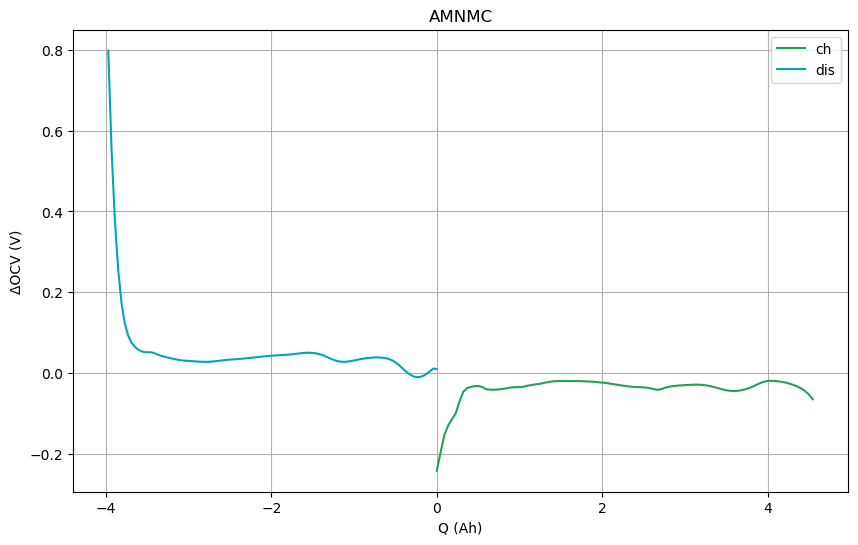

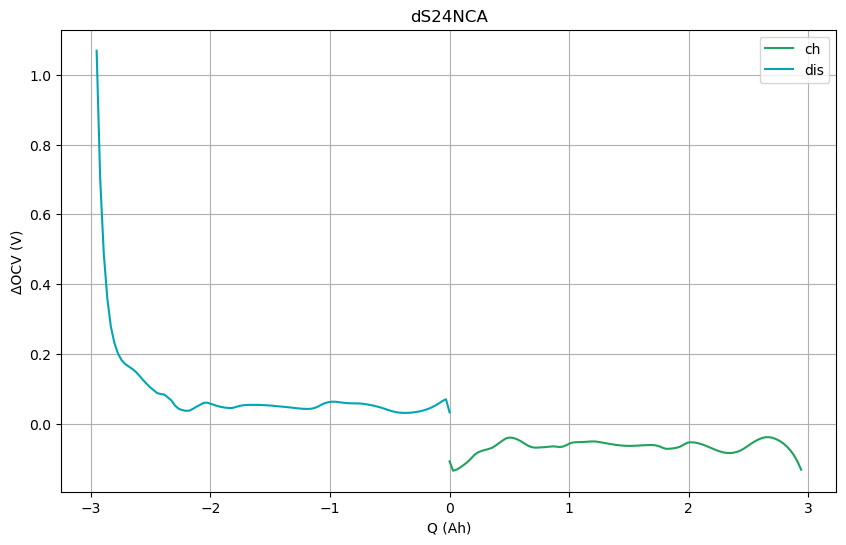

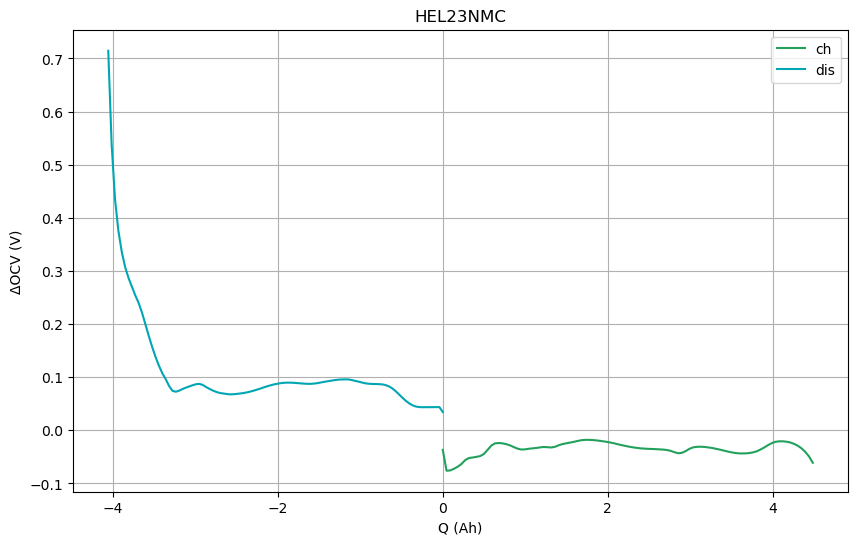

In [7]:
        
colors = ['#22a15c', '#00a6b3', '#cc0000', '#ff8000', '#808080',"yellow"]
color_index=0
for cell, directions in DeltaOCV_2.items():
    plt.figure(figsize=(10, 6))
    plt.title(f"{cell}")
    
    color_index=0
    # Schleife über die Lade- und Entladerichtungen (ch und dis)
    for direction, temps in directions.items():
            plt.plot(directions[direction][:,0],directions[direction][:,1],label=direction,color=colors[color_index])
            color_index += 1

    # Plot-Anpassungen und Anzeige
    plt.xlabel("Q (Ah)")
    plt.ylabel("ΔOCV (V)")
    plt.legend()
    plt.grid()
    plt.show() 

In [ ]:
Delta_lade={}
for cell, directions in DeltaOCV_2.items():
    cap1=directions["dis"][:,0]
    vol1=directions["dis"][:,1]
    
    cap2=directions["ch"][:,0]
    vol2=directions["ch"][:,1]
    
    cap_gleich=np.linspace(max(min(cap1),min(cap2)),min(max(cap1),max(cap2)),1000)
    int1=interp1d(cap1,vol1,kind='linear')
    int2=interp1d(cap2,vol2,kind='linear')
    int_vol1=int1(cap_gleich)
    int_vol2=int2(cap_gleich)
    
    delta_vol=int_vol1+int_vol2
    Delta_lade[cell]=np.array([cap_gleich,delta_vol]).T

for cell in Delta_lade.keys():
    plt.figure(figsize=(10, 6))
    plt.title(f"{cell}")
    
    plt.plot(Delta_lade[cell][:,0],Delta_lade[cell][:,1])
    plt.xlabel("Q (Ah)")
    plt.ylabel("ΔOCV (V)")
    plt.legend()
    plt.grid()
    plt.show() 
    